<a href="https://colab.research.google.com/github/llpk79/AVLTree/blob/master/Paul_K_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import matplotlib.pyplot as plt

In [2]:
import random
dir(random)  # Reminding ourselves what we can do here


['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=71.62433323545403, mobile=True), User(purchased=True, time_on_site=217.67269842930097, mobile=True), User(purchased=False, time_on_site=161.34129204756917, mobile=True), User(purchased=False, time_on_site=113.06746230819539, mobile=True), User(purchased=False, time_on_site=263.5807066194229, mobile=True), User(purchased=False, time_on_site=286.39595781946264, mobile=True), User(purchased=True, time_on_site=46.24085472595567, mobile=True), User(purchased=True, time_on_site=108.83008245611913, mobile=True), User(purchased=True, time_on_site=60.5034371662766, mobile=False), User(purchased=False, time_on_site=11.32057790680364, mobile=True)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

purchased  time_on_site  mobile
0       True     71.624333    True
1       True    217.672698    True
2      False    161.341292    True
3      False    113.067462    True
4      False    263.580707    True

In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site  5.057388    5.444898    5.813777    5.988364    6.370240    \
purchased                                                                  
False                  1           0           0           0           1   
True                   0           1           1           1           0   

time_on_site  6.933227    7.262434    8.100358    8.463069    9.009675    \
purchased                                                                  
False                  1           0           1           1           0   
True                   0           1           0           0           1   

time_on_site     ...      563.637440  564.804772  569.572486  570.838466  \
purchased        ...                                                       
False            ...               0           1           1           1   
True             ...               1           0           0           0   

time_on_site  573.085701  577.801689  578.014432  589.607311  592.614438  \
purchased                                                                  
False                  0           0           0           1           1   
True                   1           1           1           0           0   

time_on_site  596.041883  
purchased                 
False                  0  
True                   1  

[2 rows x 1000 columns]

In [7]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 10)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site  (4.466, 64.156]  (64.156, 123.254]  (123.254, 182.353]  \
purchased                                                              
False                     107                112                 113   
True                       48                 66                  67   

time_on_site  (182.353, 241.451]  (241.451, 300.55]  (300.55, 359.648]  \
purchased                                                                
False                         85                102                 22   
True                          75                 82                  8   

time_on_site  (359.648, 418.747]  (418.747, 477.845]  (477.845, 536.943]  \
purchased                                                                  
False                         17                  21                  17   
True                          10                  11                  11   

time_on_site  (536.943, 596.042]  
purchased                         
False                         11  
True                          15

In [8]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site  (4.466, 64.156]  (64.156, 123.254]  (123.254, 182.353]  \
purchased                                                              
False                0.690323           0.629213            0.627778   
True                 0.309677           0.370787            0.372222   

time_on_site  (182.353, 241.451]  (241.451, 300.55]  (300.55, 359.648]  \
purchased                                                                
False                    0.53125           0.554348           0.733333   
True                     0.46875           0.445652           0.266667   

time_on_site  (359.648, 418.747]  (418.747, 477.845]  (477.845, 536.943]  \
purchased                                                                  
False                    0.62963             0.65625            0.607143   
True                     0.37037             0.34375            0.392857   

time_on_site  (536.943, 596.042]  
purchased                         
False                   0.423077  
True                    0.576923

In [9]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile     False     True 
purchased                 
False      0.672  0.585333
True       0.328  0.414667

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
           rownames=['device'],
           colnames=['purchased', 'time_on_site'],
           normalize='index')

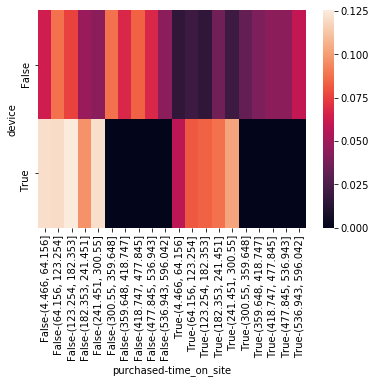

In [11]:
import seaborn as sns
sns.heatmap(ct)

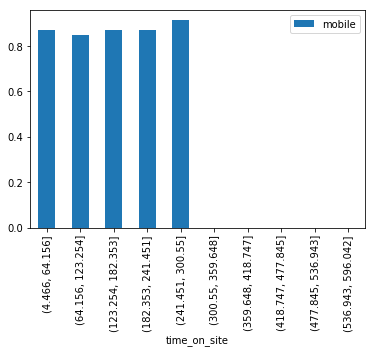

In [12]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

pd.pivot_table(
    user_data, values='mobile', index=time_bins).plot.bar();

In [13]:
user_data['time_on_site'].plot.density()

In [14]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.466, 64.156]     0.095238  0.207289  0.048780  0.141479
(64.156, 123.254]   0.130952  0.205011  0.060976  0.196141
(123.254, 182.353]  0.113095  0.214123  0.048780  0.202572
(182.353, 241.451]  0.071429  0.166287  0.109756  0.212219
(241.451, 300.55]   0.065476  0.207289  0.060976  0.247588
(300.55, 359.648]   0.130952  0.000000  0.097561  0.000000
(359.648, 418.747]  0.101190  0.000000  0.121951  0.000000
(418.747, 477.845]  0.125000  0.000000  0.134146  0.000000
(477.845, 536.943]  0.101190  0.000000  0.134146  0.000000
(536.943, 596.042]  0.065476  0.000000  0.182927  0.000000

In [15]:
ct.plot()

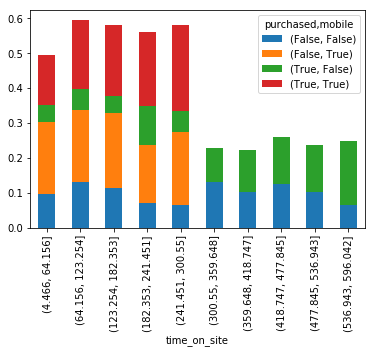

In [16]:
ct.plot(kind='bar', stacked=True)

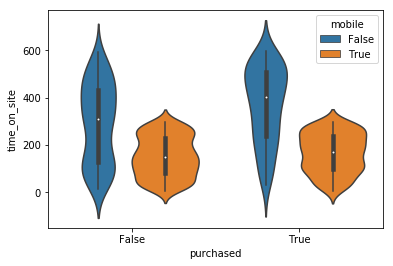

In [17]:
sns.violinplot(user_data['purchased'],user_data['time_on_site'],hue=user_data['mobile'])

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [18]:
!curl 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv' -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17574  100 17574    0     0   120k      0 --:--:-- --:--:-- --:--:--  120k


In [19]:
df = pd.read_csv('persons.csv')
df.head()

Unnamed: 0  age  weight  exercise_time
0           0   44     118            192
1           1   41     161             35
2           2   46     128            220
3           3   39     216             57
4           4   28     116            182

In [20]:
df.describe()

Unnamed: 0          age       weight  exercise_time
count  1200.000000  1200.000000  1200.000000    1200.000000
mean    599.500000    48.396667   153.540833     134.910833
std     346.554469    18.166802    35.132182      85.548895
min       0.000000    18.000000   100.000000       0.000000
25%     299.750000    33.000000   125.000000      65.000000
50%     599.500000    48.000000   149.000000     122.000000
75%     899.250000    64.000000   180.250000     206.000000
max    1199.000000    80.000000   246.000000     300.000000

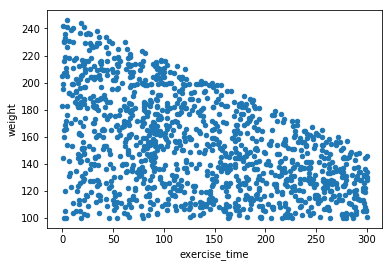

In [21]:
df.plot.scatter('exercise_time', 'weight')

This is about what I would expect. More exercise correlates with lower weight.

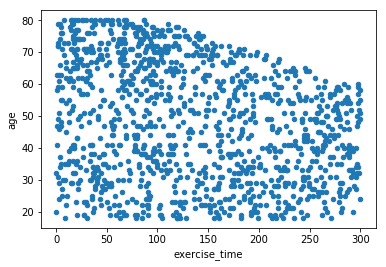

In [22]:
df.plot.scatter('exercise_time', 'age')

Now this I didn't expect! More exercise makes you litteraly younger!!

Just kidding. Although I think thats the spurious claim that could be made with this data.

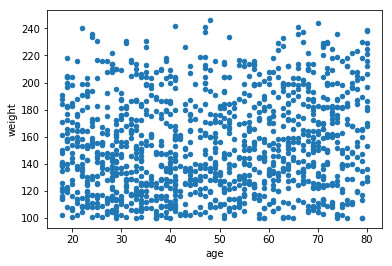

In [23]:
df.plot.scatter('age', 'weight')

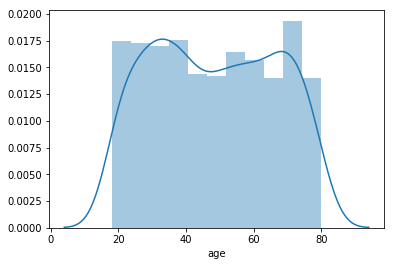

In [24]:
sns.distplot(df.age)

Not exactly distributed normally. No huge skew either.

In [25]:
df.columns
# Drop the column repeating the index.
df = df.drop(columns=['Unnamed: 0'])
df.head()

age  weight  exercise_time
0   44     118            192
1   41     161             35
2   46     128            220
3   39     216             57
4   28     116            182

In [26]:
# Bucketize our continuous data.
age_bins = pd.cut(df['age'], 5)  # 5 equal-sized bins
work_bins = pd.cut(df.exercise_time, 5)
weight_bins = pd.cut(df.weight, 5)

# Do that crosstab thing we learned about in lecture.
ct = pd.crosstab([work_bins, age_bins], weight_bins)
ct

weight                         (99.854, 129.2]  (129.2, 158.4]  \
exercise_time  age                                               
(-0.3, 60.0]   (17.938, 30.4]               10               7   
               (30.4, 42.8]                  8              10   
               (42.8, 55.2]                  7               7   
               (55.2, 67.6]                  7               6   
               (67.6, 80.0]                 21              14   
(60.0, 120.0]  (17.938, 30.4]                9              15   
               (30.4, 42.8]                 19               8   
               (42.8, 55.2]                  6               9   
               (55.2, 67.6]                 10              20   
               (67.6, 80.0]                 21              24   
(120.0, 180.0] (17.938, 30.4]               17              20   
               (30.4, 42.8]                 19               8   
               (42.8, 55.2]                  9              13   
               (55.2, 67.6]                 13              14   
               (67.6, 80.0]                 13              12   
(180.0, 240.0] (17.938, 30.4]               19              29   
               (30.4, 42.8]                 25              15   
               (42.8, 55.2]                 18               7   
               (55.2, 67.6]                 12              19   
               (67.6, 80.0]                  5               4   
(240.0, 300.0] (17.938, 30.4]               25              15   
               (30.4, 42.8]                 33              21   
               (42.8, 55.2]                 38              26   
               (55.2, 67.6]                 11              12   

weight                         (158.4, 187.6]  (187.6, 216.8]  (216.8, 246.0]  
exercise_time  age                                                             
(-0.3, 60.0]   (17.938, 30.4]              11              17               7  
               (30.4, 42.8]                10              17               7  
               (42.8, 55.2]                11               9               7  
               (55.2, 67.6]                10              15               8  
               (67.6, 80.0]                19              18              15  
(60.0, 120.0]  (17.938, 30.4]              12              10               0  
               (30.4, 42.8]                16              12               0  
               (42.8, 55.2]                14              12               1  
               (55.2, 67.6]                19              21               1  
               (67.6, 80.0]                32              18               7  
(120.0, 180.0] (17.938, 30.4]              10               7               0  
               (30.4, 42.8]                13               2               0  
               (42.8, 55.2]                12               5               0  
               (55.2, 67.6]                 6               7               0  
               (67.6, 80.0]                15               8               0  
(180.0, 240.0] (17.938, 30.4]              13               0               0  
               (30.4, 42.8]                 7               0               0  
               (42.8, 55.2]                 9               0               0  
               (55.2, 67.6]                 9               1               0  
               (67.6, 80.0]                 0               0               0  
(240.0, 300.0] (17.938, 30.4]               3               0               0  
               (30.4, 42.8]                 3               0               0  
               (42.8, 55.2]                 3               0               0  
               (55.2, 67.6]                 1               0               0

Ummm, what? That's not understandable. Let's make a picture.

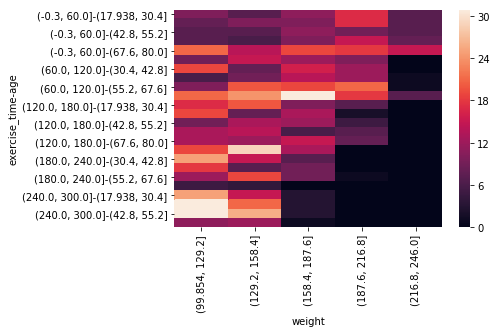

In [27]:
sns.heatmap(ct, robust=True)

If one really looks at that, one may see some relationships.

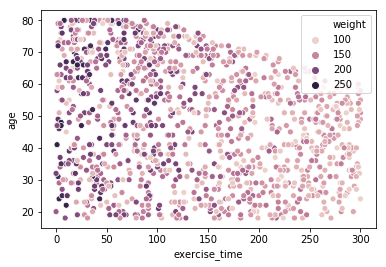

In [28]:
sns.scatterplot(df.exercise_time, df.age, df.weight)

That is better. Still hard to look at.

In [29]:
sns.swarmplot(df.exercise_time, df.age, weight_bins)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


This looks pretty good to my eye. At every age point, it's fairly easy to tell that more exercise correlates with lower weight.

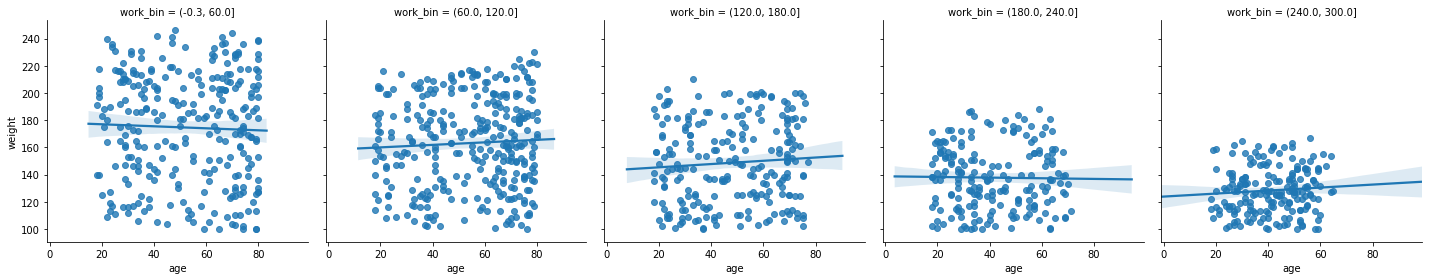

In [126]:
# This bit is from Richmond Macaspac. 

#relationship of age and weight; control for excercise_time
df['age_bin'] = age_bins
df['weight_bin'] = weight_bins
df['work_bin'] = work_bins
df.head()

g = sns.FacetGrid(df, col="work_bin", height=4)
g.map(sns.regplot, "age", "weight");

In [127]:
g = sns.FacetGrid(df, col="age_bin", height=4)
g.map(sns.regplot, "exercise_time", "weight");

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

      All are continuous for our purposes.
      
2.  What are the relationships between the variables?

      Weight is dependent on exercise time. Age is the confounding variable.
      
3.  Which relationships are "real", and which spurious?

      The "real" relationship is between weight and exercise time. Ther spurious one is between exercise and age.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)